## Overview ##

This is a starter notebook inspired by last year's [Logistic Regression on Tournament Seeds by Kasper P. Lauritzen](https://www.kaggle.com/kplauritzen/notebookde27b18258?scriptVersionId=804590) starter kernel. It creates a basic logistic regression model based on the seed differences between teams. 

Note that the predictions for Stage 1's sample submissions file are already based on known outcomes, and the Tourney data this model is trained on includes that data. For Stage 2, you will be predicting future outcomes based on the teams selected for the tournament on March 11.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


## Load the training data ##
We're keeping it simple & using only 2 files for this model: the Tourney seeds & Compact results.

In [3]:
data_dir = '../input/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_reg = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')

In [4]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [6]:
df_reg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [7]:
df_reg['ScoreDiff'] = df_reg['WScore'] - df_reg['LScore']
df_reg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreDiff
0,1985,20,1228,81,1328,64,N,0,17
1,1985,25,1106,77,1354,70,H,0,7
2,1985,25,1112,63,1223,56,H,0,7
3,1985,25,1165,70,1432,54,H,0,16
4,1985,25,1192,86,1447,74,H,0,12


In [8]:
df_reg_wins = pd.DataFrame()
df_reg_wins['ScoreDiff'] = df_reg['ScoreDiff']
df_reg_wins['TeamID'] = df_reg['WTeamID']
df_reg_wins['Season'] = df_reg['Season']

df_reg_losses = pd.DataFrame()
df_reg_losses['ScoreDiff'] = -df_reg['ScoreDiff']
df_reg_losses['TeamID'] = df_reg['LTeamID']
df_reg_losses['Season'] = df_reg['Season']

df_reg_scorediff = pd.concat((df_reg_wins, df_reg_losses))
df_reg_scorediff.head()

,ScoreDiff,TeamID,Season
0,17,1228,1985
1,7,1106,1985
2,7,1112,1985
3,16,1165,1985
4,12,1192,1985


In [9]:
df_avgScoreDiff = df_reg_scorediff.groupby(['Season','TeamID'], as_index=False).mean()
df_avgScoreDiff.tail()

,Season,TeamID,ScoreDiff
10532,2017,1460,1.400000
10533,2017,1461,0.566667
10534,2017,1462,3.264706
10535,2017,1463,2.392857
10536,2017,1464,-7.187500


First, we'll simplify the datasets to remove the columns we won't be using and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

In [10]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [11]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


## Merge seed for each team ##
Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [12]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_dummy2 = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_dummy2['SeedDiff'] = df_dummy2.WSeed - df_dummy2.LSeed

df_winavgscorediff = df_avgScoreDiff.rename(columns={'TeamID':'WTeamID', 'ScoreDiff':'WAvgScoreDiff'})
df_lossavgscorediff = df_avgScoreDiff.rename(columns={'TeamID':'LTeamID', 'ScoreDiff':'LAvgScoreDiff'})
df_dummy3 = pd.merge(left=df_dummy2, right=df_winavgscorediff, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy3, right=df_lossavgscorediff, how='left', on=['Season', 'LTeamID'])
df_concat['ScoreDiffDiff'] = df_concat.WAvgScoreDiff - df_concat.LAvgScoreDiff
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff,WAvgScoreDiff,LAvgScoreDiff,ScoreDiffDiff
0,1985,1116,1234,9,8,1,3.636364,10.466667,-6.830303
1,1985,1120,1345,11,6,5,3.689655,3.800000,-0.110345
2,1985,1207,1250,1,16,-15,15.666667,-4.448276,20.114943
3,1985,1229,1425,9,8,1,5.962963,3.785714,2.177249
4,1985,1242,1325,3,14,-11,5.633333,4.555556,1.077778


Now we'll create a dataframe that summarizes wins & losses along with their corresponding seed differences. This is the meat of what we'll be creating our model on.

In [13]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['ScoreDiffDiff'] = df_concat['ScoreDiffDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['ScoreDiffDiff'] = -df_concat['ScoreDiffDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,ScoreDiffDiff,Result
0,1,-6.830303,1
1,5,-0.110345,1
2,-15,20.114943,1
3,1,2.177249,1
4,-11,1.077778,1


In [14]:
#X_train = df_predictions.SeedDiff.values.reshape(-1,1)
X_train = df_predictions[['SeedDiff','ScoreDiffDiff']]
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the model ##
Use a basic logistic regression to train the model. You can set different C values to see how performance changes.

In [25]:
type(X_train.values)

numpy.ndarray

In [41]:
X_train.head()

,SeedDiff,ScoreDiffDiff
1466,1,-1.759358
1243,8,-1.311905
1112,-5,9.010417
1064,4,4.133333
1966,5,6.277040


In [50]:
import xgboost as xgb

# couldn't get the conversion to matrix to work...
#X_train_matrix = xgb.DMatrix(X_train.values)
#y_train_matrix = xgb.DMatrix(y_train)

gbm = xgb.XGBClassifier(max_depth=1000, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)

In [31]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5443, with best C: 0.001


In [40]:
#X = np.arange(-10, 10).reshape(-1, 1)
#preds = clf.predict_proba(X)[:,1]

#plt.plot(X, preds)
#plt.xlabel('Team1 seed - Team2 seed')
#plt.ylabel('P(Team1 will win)')

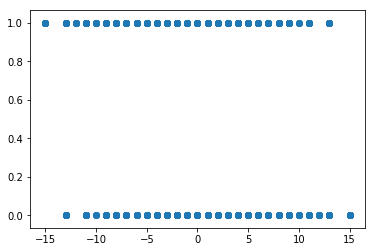

In [18]:
plt.scatter(df_predictions.SeedDiff, df_predictions.Result)

Plotting validates our intuition, that the probability a team will win decreases as the seed differential to its opponent decreases.

In [33]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [34]:
X_test = np.zeros(shape=(n_test_games, 2))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    t1_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == t1) & (df_avgScoreDiff.Season == year)].ScoreDiff.values[0]
    t2_avg_score_diff = df_avgScoreDiff[(df_avgScoreDiff.TeamID == t2) & (df_avgScoreDiff.Season == year)].ScoreDiff.values[0]
    diff_seed = t1_seed - t2_seed
    score_diffdiff = t1_avg_score_diff - t2_avg_score_diff
    X_test[ii, 0] = diff_seed
    X_test[ii, 1] = score_diffdiff 

In [44]:
X_test_DF = pd.DataFrame(X_test, columns=['SeedDiff', 'ScoreDiffDiff'])

## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [51]:
#preds = clf.predict_proba(X_test)[:,1]
preds = gbm.predict_proba(X_test_DF)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.118182
1,2014_1107_1112,0.050000
2,2014_1107_1113,0.050000
3,2014_1107_1124,0.475678
4,2014_1107_1140,0.851170


Lastly, create your submission file!

In [52]:
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)